In [1]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

In [2]:
from pbcpy.base import Cell
from pbcpy.grid import Grid
#

In [3]:
from pbcpy.grid_functions import Grid_Function_Base, Grid_Function, Grid_Function_Reciprocal, Grid_Space

In [4]:
from pbcpy.functionals import Functional

In [5]:
from pbcpy.local_functionals_utils import ThomasFermiEnergy, ThomasFermiPotential
from pbcpy.local_functionals_utils import vonWeizsackerEnergy, vonWeizsackerPotential

In [6]:
from pbcpy.formats.qepp import PP
from pbcpy.formats.xsf import XSF

In [7]:
mol = PP(filepp='Al_fde_rho.pp').read()

In [8]:
density = mol.plot

In [9]:
grid_real             = Grid_Space(density.grid.at,density.grid.nr)
dens_real_space       = Grid_Function(grid_real,griddata_3d=density.values)

In [10]:
ThomasFermi = Functional(energydensity=ThomasFermiEnergy(dens_real_space),
                         potential=ThomasFermiPotential(dens_real_space))

In [11]:
vonWeizsacker = Functional(energydensity=vonWeizsackerEnergy(dens_real_space),
                           potential=vonWeizsackerPotential(dens_real_space))

In [12]:
GEA2 = Functional(energydensity=ThomasFermiEnergy(dens_real_space).sum(
                      vonWeizsackerEnergy(dens_real_space).dot(g=1.0/9.0)),
                  potential=ThomasFermiPotential(dens_real_space).sum(
                      vonWeizsackerPotential(dens_real_space).dot(g=1.0/9.0)))

In [13]:
Energy = GEA2.energydensity.integral()
print(Energy)

1.83537530611


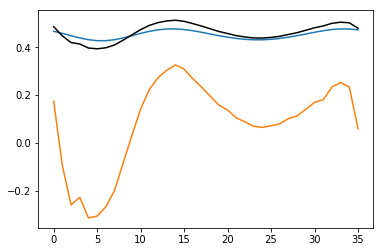

In [14]:
plt.plot(ThomasFermi.potential.values[:,25,36])
plt.plot(vonWeizsacker.potential.values[:,25,36])
plt.plot(GEA2.potential.values[:,25,36],c='black')
#plt.ylim(-0.2,0.5)
plt.show()

In [15]:
def LindhardFunction(eta,lbda,mu):
    '''
    The Inverse Lindhard Function
    
    Attributes
    ----------
    eta: numpy array
    lbda, mu: floats (TF and vW contributions)
    
    '''
    if isinstance(eta, (np.ndarray, np.generic)):
        #
        cond0 = ((eta > 0.0) & (np.abs(eta - 1.0) > 1.0e-10))
        cond1 = eta < 1.0e-10 
        cond2 = np.abs(eta - 1.0) < 1.0e-10
        cond3 = eta > 3.65
        cond11 = eta > 1.0e-10
        
        invEta2 = eta.copy()
        invEta2[cond11] = 1.0 / eta[cond11]**2

        #    
        indx0 = cond0
        indx1 = np.where( cond1 )
        indx2 = np.where( cond2 )
        indx3 = np.where( cond3 )
        
        LindG = eta.copy()
        
        
        LindG[indx0] = 1.0 / (0.5 + 0.25*(1.0-eta[indx0]**2)* 
                    np.log((1.0 + eta[indx0])/np.abs(1.0-eta[indx0]))/eta[indx0])-3.0 * mu * eta[indx0]**2 - lbda

        LindG[indx1] = 1.0 - lbda + eta[indx1]**2 * (1.0 / 3.0 - 3.0 * mu)
        LindG[indx2] = 2.0 - lbda - 3.0 * mu + 20.0 * (eta[indx2]-1.0)
        LindG[indx3] = 3.0*(1.0-mu)*eta[indx3]**2-lbda-0.6   \
                + invEta2[indx3] * (-0.13714285714285712     \
                + invEta2[indx3] * (-6.39999999999999875E-2  \
                + invEta2[indx3] * (-3.77825602968460128E-2  \
                + invEta2[indx3] * (-2.51824061652633074E-2  \
                + invEta2[indx3] * (-1.80879839616166146E-2  \
                + invEta2[indx3] * (-1.36715733124818332E-2  \
                + invEta2[indx3] * (-1.07236045520990083E-2  \
                + invEta2[indx3] * (-8.65192783339199453E-3  \
                + invEta2[indx3] * (-7.1372762502456763E-3   \
                + invEta2[indx3] * (-5.9945117538835746E-3   \
                + invEta2[indx3] * (-5.10997527675418131E-3  \
                + invEta2[indx3] * (-4.41060829979912465E-3  \
                + invEta2[indx3] * (-3.84763737842981233E-3  \
                + invEta2[indx3] * (-3.38745061493813488E-3  \
                + invEta2[indx3] * (-3.00624946457977689E-3) \
                                   ))))))))))))))
        return LindG

In [16]:
def MGP_kernel(q,rho0,LumpFactor,MaxPoints):
        ''' 
        The MGP Kernel
        '''
        #cTF_WT = 2.87123400018819
        cTF = np.pi**2/(3.0 * np.pi**2)**(1.0/3.0)
        tkf = 2.0 * (3.0 * rho0 * np.pi**2)**(1.0/3.0)
        t_var  = 1.0/(MaxPoints)
        deltat = 1.0/(MaxPoints)
        dt     = deltat / 100

        kertmp = np.zeros(np.shape(q))
        
        for i_var in range(MaxPoints):
            kertmp = kertmp + \
            0.5*((LindhardFunction(q/(tkf*(t_var+dt)**(1.0/3.0)),-0.60,1.0) \
            -LindhardFunction(q/(tkf*(t_var-dt)**(1.0/3.0)),-0.60,1.0))/dt)* \
            t_var**(5.0/6.0)
            #
            t_var = t_var + deltat
            
        tmpker1 = -1.2*kertmp*deltat
        indx    = np.where(q != 0)
        tmpker2 = kertmp.copy()
        tmpker2[indx] = 4*np.pi*sp.erf(q[indx])**2*LumpFactor*np.exp(-q[indx]**2*LumpFactor)/q[indx]**2/cTF
        indx    = np.where(q == 0)
        tmpker2[indx] = q[indx]**2
        tmpker3 = 1.2*LindhardFunction(q/tkf,1.0,1.0) 
        
        return (tmpker1 + tmpker2 + tmpker3)*cTF #*cTF_WT

In [17]:
def WT_kernel(q,rho0):
        ''' 
        The WT Kernel
        '''
        cTF = np.pi**2/(3.0 * np.pi**2)**(1.0/3.0) #2.87123400018819
        tkf = 2.0 * (3.0 * rho0 * np.pi**2)**(1.0/3.0)
                
        return (1.2*LindhardFunction(q/tkf,1.0,1.0))*cTF

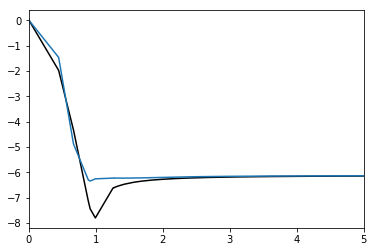

In [18]:
#
# Kernels from the real Al density and G-points
#
gmpker = MGP_kernel(grid_real.reciprocal_grid.dist_values(),dens_real_space.integral()/mol.cell.omega,0.3,100)
wtker = WT_kernel(grid_real.reciprocal_grid.dist_values(),dens_real_space.integral()/mol.cell.omega)
eta = grid_real.reciprocal_grid.dist_values()/(2.0 * (3.0 * dens_real_space.integral()/mol.cell.omega * np.pi**2)**(1.0/3.0))

reta = np.reshape(eta,36*36*72)
rmgp = np.reshape(gmpker,36*36*72)
rwt = np.reshape(wtker,36*36*72)
indx = np.argsort(reta)

plt.plot(reta[indx],rwt[indx],color='black')
plt.plot(reta[indx],rmgp[indx])
#plt.ylim(-1.94,-1.9)
plt.xlim(0,5)
plt.show()

#
# Cute-looking kernels
#
q=np.linspace(0.1,4,1000)
gmpker = MGP_kernel(q,dens_real_space.integral()/mol.cell.omega,0.3,500)
wtker = WT_kernel(q,dens_real_space.integral()/mol.cell.omega)
eta = q/(2.0 * (3.0 * dens_real_space.integral()/mol.cell.omega * np.pi**2)**(1.0/3.0))
plt.plot(eta,wtker,color='black')
plt.plot(eta,gmpker)
plt.show()

In [19]:
wtker = WT_kernel(grid_real.reciprocal_grid.dist_values(),dens_real_space.integral()/mol.cell.omega)

In [25]:
WTdens = dens_real_space.energy_density(kernel=wtker,a=(5.0/6.0),b=(5.0/6.0),c=1.0)
WTpot = dens_real_space.energy_potential(kernel=wtker,a=(5.0/6.0),c=1.0)
WTpotential = Grid_Function(dens_real_space.grid_space,griddata_3d=(5.0/6.0)*2.0*WTpot.values*dens_real_space.values**(5.0/6.0-1.0))

In [26]:
WT_Functional = Functional( 
    energydensity=WTdens.dot(vonWeizsacker.energydensity.dot(ThomasFermi.energydensity)), \
    potential=WTpotential.dot(vonWeizsacker.potential.dot(ThomasFermi.potential)),kernel=wtker)

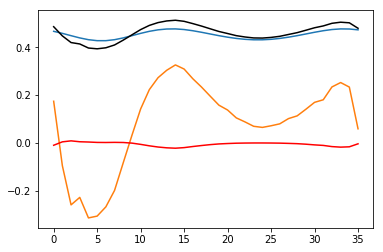

In [27]:
plt.plot(ThomasFermi.potential.values[:,25,36])
plt.plot(vonWeizsacker.potential.values[:,25,36])
plt.plot(GEA2.potential.values[:,25,36],c='black')
plt.plot(WT_Functional.potential.values[:,25,36],c='red')

#plt.ylim(-0.2,0.5)
plt.show()